In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
import matplotlib.dates as mdates
import numpy.matlib
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.model_selection import train_test_split
from dateutil.parser import parse
import pmdarima as pm
from sklearn.metrics import mean_squared_error


In [2]:
pd.set_option('display.max_columns', 30)
df = pd.read_csv('weatherAUS.csv', index_col=0, parse_dates=True)


In [3]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Preprocessing:Extract MaxTemp Data for Sydney



In [4]:
df=df[['Location','MaxTemp']]
df=df[df.Location=='Sydney']

In [5]:
df.dropna(subset=["MaxTemp"], inplace=True)


In [6]:
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter
df['Month'] = df.index.month
df['Weakday'] = df.index.weekday
df['Day'] = df.index.day

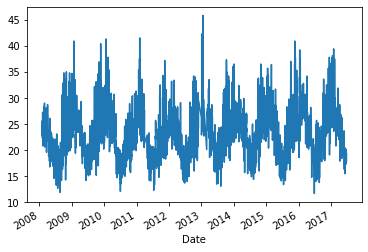

In [7]:
df['MaxTemp'].plot();
#df['Rainfall'].loc['2008-07':'2008-08'].plot()


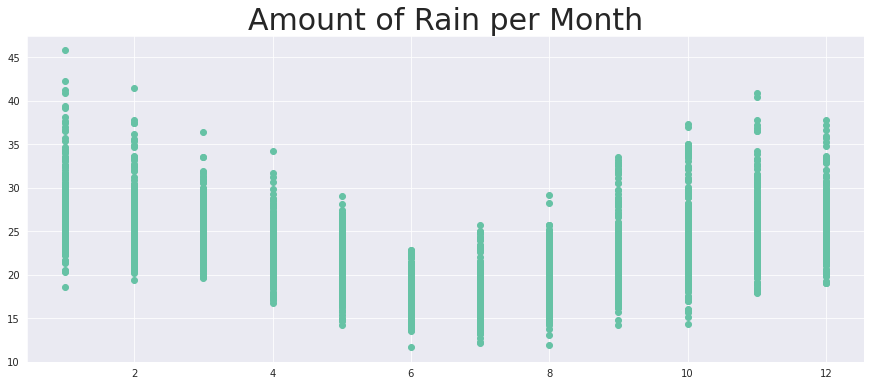

In [8]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=[15,6])
plt.scatter(df['Month'], df['MaxTemp'])
plt.title( "Amount of Rain per Month",size = 30)
plt.show()

In [9]:
#Outliers
df[df.MaxTemp>45]

,Location,MaxTemp,Year,Quarter,Month,Weakday,Day
Date,,,,,,,
2013-01-18,Sydney,45.8,2013,1,1,4,18


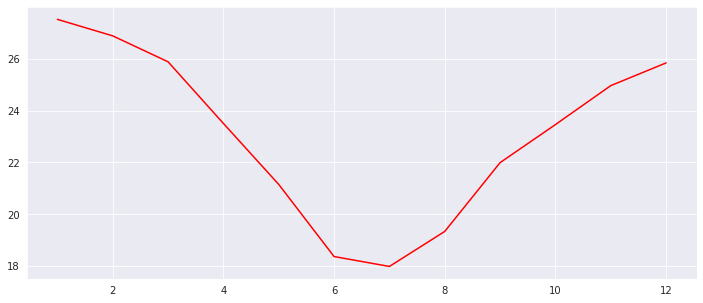

In [10]:
monthly_mean = df.groupby("Month").aggregate("mean")["MaxTemp"]
plt.figure(figsize=(12,5))
plt.plot(monthly_mean.index, monthly_mean, color='r')
plt.show()


In [11]:
monthly_mean

Month
1     27.517204
2     26.880784
3     25.881290
4     23.504444
5     21.153548
6     18.373129
7     17.991398
8     19.341935
9     21.994052
10    23.460650
11    24.962547
12    25.838211
Name: MaxTemp, dtype: float64

In [12]:
df.MaxTemp

Date
2008-02-01    22.4
2008-02-02    25.6
2008-02-03    24.5
2008-02-04    22.8
2008-02-05    25.7
              ... 
2017-06-21    19.6
2017-06-22    19.2
2017-06-23    17.7
2017-06-24    19.3
2017-06-25    19.3
Name: MaxTemp, Length: 3335, dtype: float64

# Deseasonalize Data

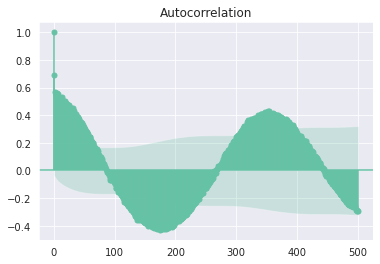

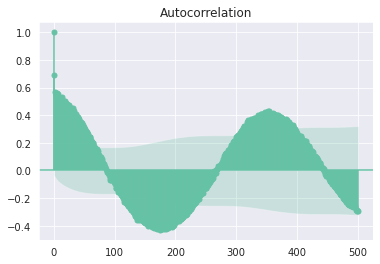

In [13]:
sm.graphics.tsa.plot_acf(df['MaxTemp'], lags=500)

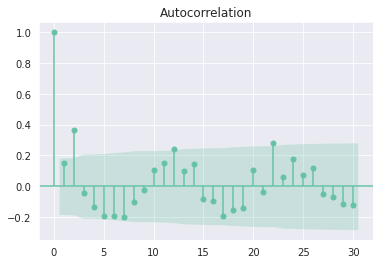

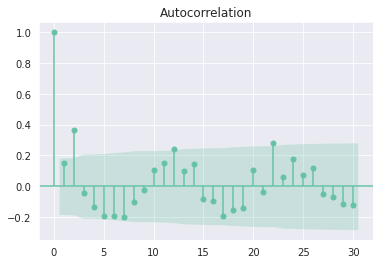

In [14]:
sm.graphics.tsa.plot_acf(df['MaxTemp'].resample('M').sum(), lags=30)

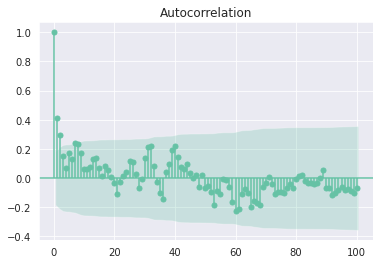

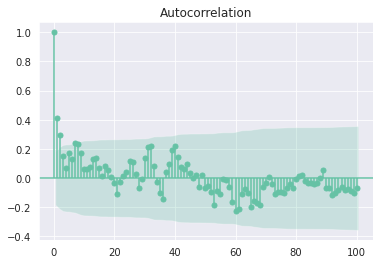

In [15]:
df_des=df.copy()
df_des=df_des.apply(lambda x: x.MaxTemp-monthly_mean[x.Month] , axis=1)
sm.graphics.tsa.plot_acf(df_des.resample('M').sum(), lags=100)

<AxesSubplot:xlabel='Date'>

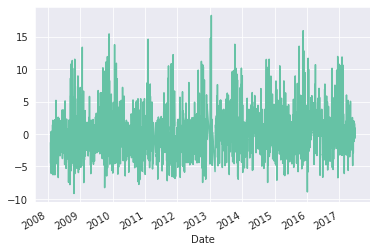

In [16]:
df_des.plot()

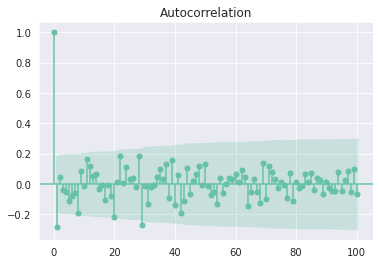

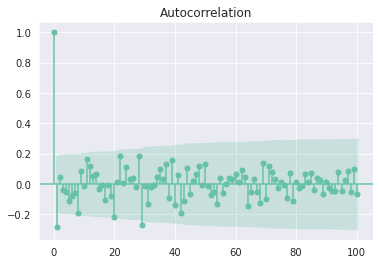

In [17]:
df_diff=df.copy()
df_diff=df['MaxTemp'].diff().dropna()
df_diff.isna().sum()
sm.graphics.tsa.plot_acf(df_diff.resample('M').sum(), lags=100)


<AxesSubplot:xlabel='Date'>

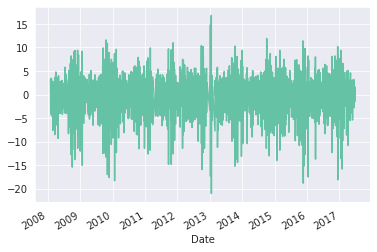

In [18]:
df_diff.plot()

<ipython-input-19-baf1405aa71f>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df_diff, model='additive',extrapolate_trend='freq',freq=365)


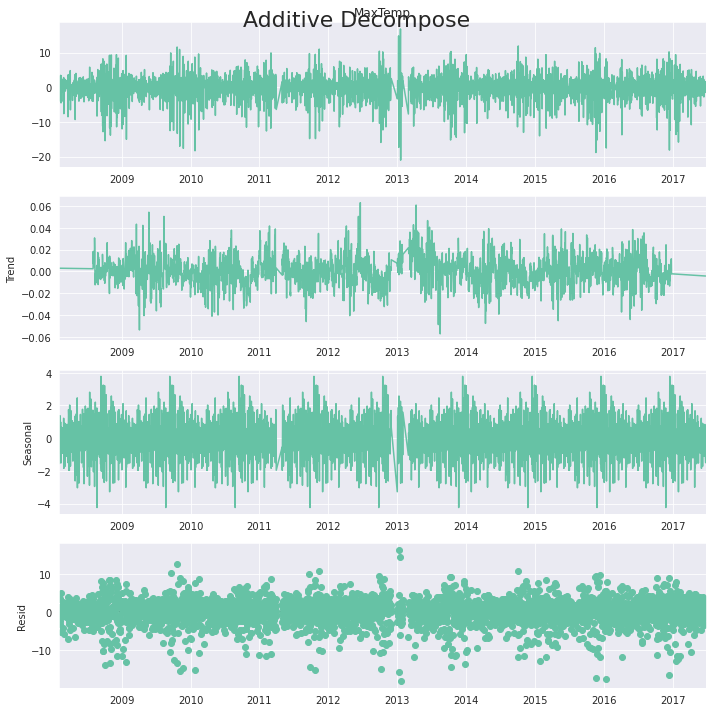

In [19]:
#seasonal decomposition does not work well with this dataset
# Additive Decomposition
result_add = seasonal_decompose(df_diff, model='additive',extrapolate_trend='freq',freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

#  ARIMA

In [20]:
#check stationarity of time series
#but only checks long term trends not necesserally seasonality
result = adfuller(df['MaxTemp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.138369
p-value: 0.000836


In [21]:
from statsmodels.tsa.arima.model import ARIMA

# 1,0,1 SARIMA Model(p,d,q,s)
model = ARIMA(df['MaxTemp'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/home/hiob/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hiob/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hiob/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                MaxTemp   No. Observations:                 3335
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8392.765
Date:                Tue, 03 Aug 2021   AIC                          16791.530
Time:                        14:29:28   BIC                          16809.866
Sample:                             0   HQIC                         16798.090
                               - 3335                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2998      0.017     17.245      0.000       0.266       0.334
ma.L1         -0.9050      0.009   -101.750      0.000      -0.922      -0.888
sigma2         8.9927      0.146     61.535      0.0

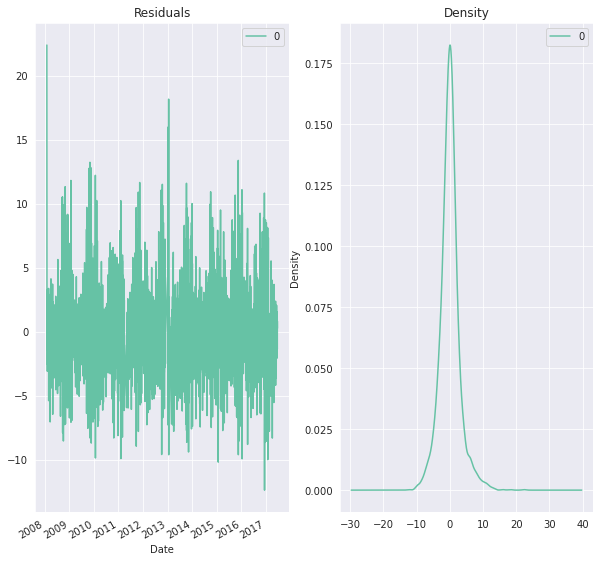

In [22]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [109]:
# Seasonal - fit stepwise auto-ARIMA
# smodel = pm.auto_arima(df['MaxTemp'], start_p=1, start_q=1,
#                          test='adf',
#                          max_p=3, max_q=3, m=12,
#                          start_P=0, seasonal=True,
#                          d=None, D=1, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

# smodel.summary()
trainsize=len(df)-4
train, test = train_test_split(df['MaxTemp'], train_size=trainsize)

# Fit your model
model = pm.auto_arima(train, start_p=1, start_q=1,
                     max_p=5, max_q=5,test='adf',seasonal=True)
                     

# make your forecasts
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True) #predict n steps into future



In [110]:
conf_int

array([[13.36097396, 25.07313619],
       [12.88385526, 25.52027055],
       [12.86473796, 25.60567371],
       [12.8466662 , 25.68944108]])

In [111]:
predictions=pd.Series(preds,index=test.index)
lower_conf = pd.Series(conf_int[:, 0], index=test.index)
upper_conf = pd.Series(conf_int[:, 1], index=test.index)


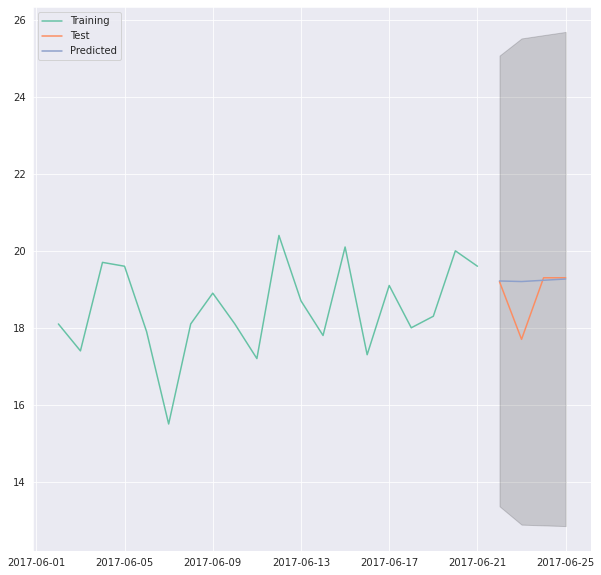

In [112]:
plt.plot(train[-20:], label="Training")
plt.plot(test,label="Test")
plt.plot(predictions, label="Predicted")

# Plot
plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')
plt.show()

In [113]:
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 0.752


In [114]:
preds

array([19.21705508, 19.2020629 , 19.23520584, 19.26805364])

In [115]:
test

Date
2017-06-22    19.2
2017-06-23    17.7
2017-06-24    19.3
2017-06-25    19.3
Name: MaxTemp, dtype: float64

In [116]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3331
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -8373.220
Date:                Tue, 03 Aug 2021   AIC                          16756.441
Time:                        15:26:18   BIC                          16786.996
Sample:                             0   HQIC                         16767.373
                               - 3331                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2041      0.068      3.007      0.003       0.071       0.337
ar.L1          0.9911      0.003    343.741      0.000       0.985       0.997
ma.L1         -0.5861      0.014    -42.783      0.000      -0.613      -0.559
ma.L2         -0.2624      0.016    -16.615      0.000      -0.293      -0.231
sigma2         8.9273      0.150     59.708      0.000       8.634       9.220
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1227.23
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.59
Prob(H) (two-sided):                  0.48   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

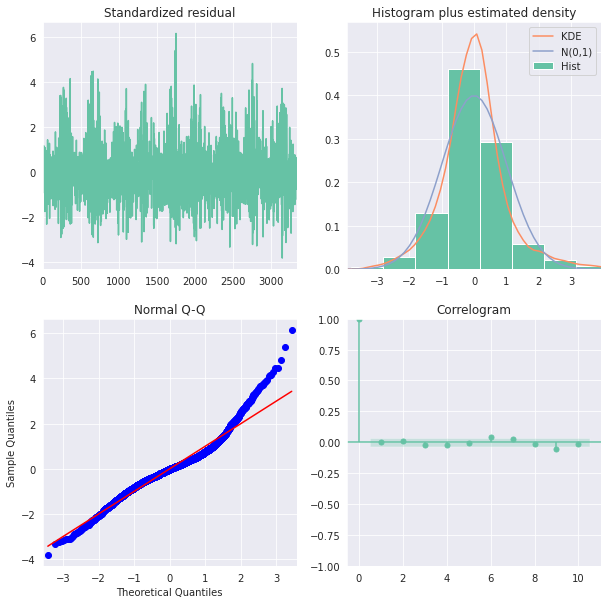

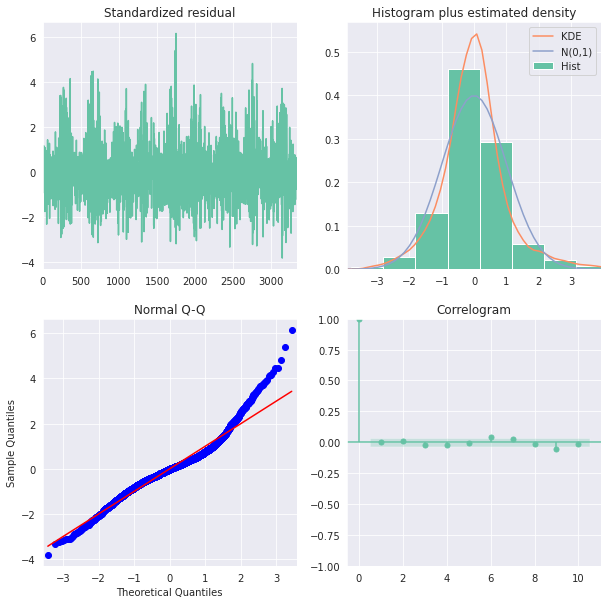

In [117]:
model.plot_diagnostics()